In [1]:
%%capture
%pip install pymc
%pip install --upgrade xarray==2022.3.0
%pip install watermark

# Imports
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

import matplotlib.pyplot as plt
import scipy.stats as st

from matplotlib.patches import Ellipse
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import SpectralEmbedding
from sklearn.impute import KNNImputer
from statsmodels.distributions.empirical_distribution import ECDF

# Set style
plt.style.use('fivethirtyeight')

# Data-driven segmentation reveals three doctor profiles
## Executive Summary
This report highlights a new, data-driven perspective on the customer base of the company. The historical approach of segmenting doctors by their region has been shown to be a poor predictor of their support or purchasing behaviour. The analysis describes here reveals **three new segments** of customers with distinct profiles that will inform product and marketing development alongside customer service needs.

The report focuses on three key questions:
1. What is the composition of each region in terms of number of doctors and their average number of purchases?
2. Is there a relationship between purchases and number of complaints?
3. Can new segments be found, and what variables best describe these new segments if they exist?

## Key Insights
- The number of doctors in each area varies a lot, from **one** to **34**, though on average there are around **10**. The number of purchases also varies, from **13** to **129**. There is no discernible pattern between these, and one small region has a very high purchase rate. 
- Given the data, there is a **75% probability** that doctors **who complain more, purchase more**, though this effect is relatively small, with higher-than-average numbers of complaints being associated with just a **6% increase** in purchases. The analysis suggests the effect could be as large as a 25% increase, or reduce purchases by 11%. 
- Segmentation analysis suggests there are **three** distinct groups of doctors, with a unique relationship to the company.

### New doctor segments:
1. **Segment One** - Doctors here have low *experience* with the company, lower rates of *purchases*, *R* and *incidence* rates, and give fewer *complaints*. They also treat fewer *unique conditions*, and have only average reported *satisfaction*. There are more *general practitioner* in this segment.
2. **Segment Two** - Doctors here have high *R* rates, give more *complaints*, and have a high level of *experience* with the company. They make relatively fewer *purchases* and seem to treat fewer *unique conditions*. This segment, the largest in number, is diffuse in terms of its members and their rank and category.
3. **Segment Three**. Doctors here make a lot of *purchases* and have high *incidence rates*, are relatively *satisfied*, and treat the most number of *unique conditions*. They make fewer *complaints* but have less *experience* with the company. They are comprised of a lot of *Ambassadors*. 

## Key recommendations
- Abandon use of region as a predictor of doctor behaviour.
- Acknowledge the association between purchases and complaints, and its uncertainty.
- Label Segment One doctors as **Inexperienced and Indifferent doctors**. This segment would benefit from marketing and raising awareness of the company to on-board doctors and increase satisfaction.
- Label Segment Two doctors as **Experienced but Unhappy doctors**. While these doctors have a longstanding relationship with the company, they have unaddressed needs and make many complaints. These would be a good audience for focus groups to understand their needs and increase satisfaction.
- Label Segment Three doctors as **Returning, Happy, and diverse doctors**. These individuals are overall positive, treating a range of conditions, and make many purchases, but have less experience with the company. Further engagement with this audience will be important to retain them as a loyal set of customers.
- Caveats: Despite a large dataset, doctors with matching observations across the range of tables were relatively few, with an effective sample size of 74 doctors. Statistical methods were used to help here but it is worth noting.

# Doctor-by-region analysis
The main data sources here are split across four tables, which briefly comprise the following information:
- `doctors` includes information on doctor category, rank, experience with the company, satisfaction, purchases, and incidence/rework rates.
- `orders` illustrates the number of orders an individual doctor has placed.
- `complaints` considers doctors and the number of complaints and complaint types they make.
- `instructions` highlights whether a doctor has leaves specific instructions on the order. 

There is missing data in the `doctors` dataset about satisfaction, which will be imputed after highlighting the doctor-by-region analysis.

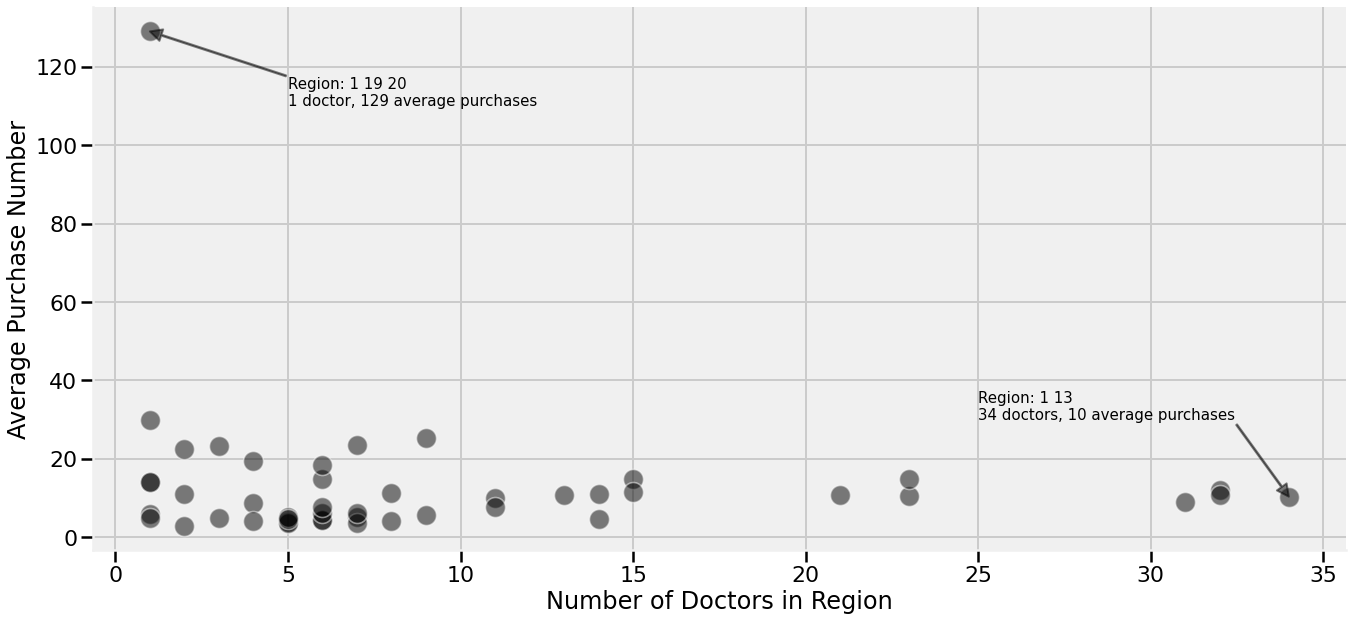

In [2]:
# Read in data files
doctors = pd.read_csv('data/doctors.csv')            # doctor details
orders = pd.read_csv('data/orders.csv')              # order details
complaints = pd.read_csv('data/complaints.csv')      # complaint details
instructions = pd.read_csv('data/instructions.csv')  # instruction details (y/n)

# Aggregate the doctors dataset
query1 = (doctors
          .groupby(by='Region', as_index=False)
          .agg(number_of_doctors=('DoctorID', pd.Series.nunique),
               average_purchase_number=('Purchases', 'mean'))
          .round(3))

# Plot
with sns.plotting_context('poster'):
    
    # Figure, axis
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    sns.despine(fig)
    
    # Scatter
    sns.scatterplot(data=query1, x='number_of_doctors', y='average_purchase_number', 
                    color='black', alpha=0.5, s=400, ax=ax)
    
    # Set labels
    ax.set(ylabel='Average Purchase Number', xlabel='Number of Doctors in Region')
    
    # Annotate some regions 
    ax.annotate('Region: 1 19 20\n1 doctor, 129 average purchases', (1, 129), (5, 110), arrowprops={'width': 1, 'color':'black', 'alpha':.5}, fontsize=15) # max purchases
    ax.annotate('Region: 1 13\n34 doctors, 10 average purchases', (34, 10.382), (25, 30), arrowprops={'width': 1, 'color':'black', 'alpha':.5}, fontsize=15) # max doctors
    

A brief glance at this chart highlights why region is a poor predictor of the number of purchases that can be made. Overall, there is no relationship between number of doctors and their average number of purchases across regions, aside from a large outlier. 

# Assessing the purchase ~ complaint association probabilistically
While there may be a simple association between purchases and complaints, the relationship may be driven by other variables (e.g. satisfaction). Using a combination of careful feature engineering and a Bayesian linear model, the influence of other variables in the dataset (see **Technical Annexe** for details) can be controlled, and the relationship between complaint number as a predictor of purchase number examined. Before modelling, 55 missing datapoints in the `satisfaction` variable were imputed, and a final sample of 74 doctors were analysed.

In [3]:
## Feature engineering
# Doctors cleaning
doctors_processed = (doctors
                     .assign(**pd.get_dummies(doctors[['Category', 'Rank']], drop_first=True))     # One hot encodes category and rank
                     .assign(Satisfaction=pd.to_numeric(doctors['Satisfaction'], errors='coerce')) # Fixes the string column of Satisfaction
                     .set_index('DoctorID')
                     .filter(regex='rate|Satisfaction|Experience|Purchases|Rank_|Category_')       # Select relevant variables
                    )

# Orders cleaning - calculate unique-condition-count - number of unique treatments
orders_processed = (orders
                    .set_index('DoctorID')               # Push doctor ID into index
                    .filter(regex='Condition [A-I]')     # Keep conditions A-I; J seems related to when devices are administered
                    .groupby('DoctorID')                 # Groupby Doctor as some doctors appear more than once
                    .apply(lambda x: x.sum(axis='rows')) # Take the sum across rows - each doctor then has a count of how many times they treat a condition
                    .gt(0)                               # where that is above zero, indicate true
                    .sum(axis='columns')                 # The sum of those booleans indicates a condition has been treated by this doctor
                    .to_frame('Unique Condition Index')
                   )

# Complaints - count the total number of complaints a given doctor gives, across complaint types
complaints_processed = (complaints
                        .groupby('DoctorID')
                        .agg(Complaints=('Qty', 'sum'))
                       )

# Merge the data and scale appropriately
z_score_these = ['Incidence rate', 'R rate', 'Satisfaction', 
                 'Experience', 'Complaints', 'Unique Condition Index']

# Merge the data together
df = (complaints_processed
      .join(doctors_processed, how='inner')
      .join(orders_processed, how='left')
     )

# Impute the missing data in Satisfaction
imputed_data = KNNImputer(n_neighbors=4).fit_transform(df)

# Recreate a dataframe, scale necessary variables
df = pd.DataFrame(imputed_data, index=df.index, columns=df.columns).apply(lambda z: st.zscore(z) if z.name in z_score_these else z)

In [4]:
%%capture
# Test association using a PyMC negative binomial model
X = df.drop(columns='Purchases')
y = df['Purchases'].values

with pm.Model(coords={'coefs': X.columns}) as bayesian_negbinom_regression:
    
    # Define priors over intercept and all coefficients
    β0 = pm.Normal('β0', mu=0, sigma=1)
    β = pm.Normal('β', mu=0, sigma=1, dims='coefs')
    
    # Compute linear predictor
    λ = β0 + pm.math.dot(X.values, β)
    
    # Take the exponent
    λ_exp = pm.Deterministic('λ_exp', pm.math.exp(λ))
    
    # Send to a Negative binomial likelihood which models the count of a variable
    α = pm.Exponential('nb', 0.01)
    pm.NegativeBinomial('likelihood', mu=λ_exp, alpha=α, observed=y)
    
    # Sample
    trace = pm.sample(2000, tune=2000, target_accept=.90, random_seed=42)


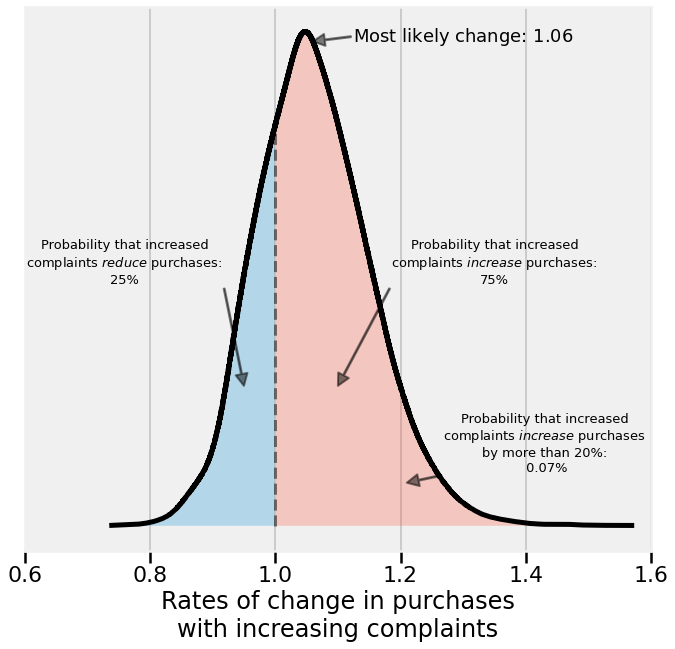

In [5]:
# Extract the posterior distribution of the "complaints" predictor
coef_trace = np.exp(trace['posterior'].sel(coefs='Complaints')['β'].values.flatten())

# Take its empirical cumulative distribution
ecdf = ECDF(coef_trace)([coef_trace]).ravel()

# and its survival function
esf = 1 - ecdf

# Build a kernel density estimate and its probability density function of the coefficient
density = st.gaussian_kde(coef_trace)
kde = density.pdf(coef_trace)

# Store as a df
traceplot = pd.DataFrame({'trace': coef_trace, 'density': kde, 'ecdf': ecdf, 'esf': esf}).round(3).sort_values(by='trace')

# Plot the trace
with sns.plotting_context('poster'):
    
    # Figure, axes
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    # Plot pdf
    ax.plot('trace', 'density', data=traceplot, lw=5, color='black')
    
    # Add a line of no effect, add mean
    ax.plot([1, 1], [0, density.pdf(1)], color='black', alpha=.5, linestyle='dashed')
    ax.set(xlim=(0.6, 1.6), yticks=[], xlabel='Rates of change in purchases\nwith increasing complaints')
    
    # Fill the ± regions in 
    ax.fill_between('trace', 'density', where=traceplot['trace'].lt(1).values, data=traceplot, alpha=.25)
    ax.fill_between('trace', 'density', where=traceplot['trace'].gt(1).values, data=traceplot, alpha=.25)
    
    # Annotate
    ax.annotate('Probability that increased\ncomplaints $reduce$ purchases: \n25%',
                (0.95, 1.3), (0.76, 2.25), arrowprops={'width': 1, 'color': 'black', 'alpha': .5},
                fontsize=13, horizontalalignment='center')
    
    ax.annotate('Probability that increased\ncomplaints $increase$ purchases: \n75%',
                (1.1, 1.3), (1.35, 2.25), arrowprops={'width': 1, 'color': 'black', 'alpha': .5},
                fontsize=13, horizontalalignment='center')
    
    ax.annotate('Probability that increased\ncomplaints $increase$ purchases\nby more than 20%:\n 0.07%',
                (1.21, 0.4), (1.43, 0.5), arrowprops={'width': 1, 'color': 'black', 'alpha': .5},
                fontsize=13, horizontalalignment='center')
    
    ax.annotate('Most likely change: $1.06$',
                (1.06, 4.5), (1.30, 4.5), arrowprops={'width': 1, 'color': 'black', 'alpha': .5},
                fontsize=18, horizontalalignment='center')

The plot illustrates the plausibility of different effects of increasing complaints on purchase rates. For example, the dashed vertical line on an effect of **1**, which indicates no change in purchases as a result of increasing complaints, we can see that the probability the effect is bigger than this - that is, increasing complaints means increasing purchases - is *75%*. Similarly, the probability is negative is 25%. The plot highlights clearly that the most likely rate of increase is **1.06**, or **6%**, but the rate is plausibly within the region of 0.89 to 1.25. From this we are able to infer the effect of increased complaints on purchases across a variety of contexts - just as an example, the probability that purchases increase by 20% with greater complaints is just 7%.

# Customer segmentation - revealing three profiles 
With the same dataset used above, machine learning techniques (see **Technical Annexe** for details) can uncover the latent structure in the data that can then be grouped together, revealing an optimal grouping of doctors. The below chart, also interactive, allows for the exploration of each segment and their distinct customer profile. Doctors were segmented using a two-feature representation of a wider feature space, specifically:
- Number of complaints
- Incidence and R rates
- Satisfaction with company
- Experience with company
- Category; Specialist or GP
- Rank; from Silver through to Titanium Plus
- Unique Condition Index; a count, per doctor, of the number of unique conditions they treat.


In [6]:
# First scale the Qty measure
df = df.assign(Purchases=st.zscore(df['Purchases']))

# Use Spectral embedding to preserve local distances in a 2D representation
spectra = SpectralEmbedding(n_components=2, random_state=42).fit_transform(df)

# Use silhouette scoring to select K with K-means
sc = {}
for k in range(2, 10):
    
    # Fit KMeans
    km = KMeans(n_clusters=k, random_state=42).fit(spectra)
    
    # Extra and score silhouette
    sc[k] = silhouette_score(spectra, km.labels_)

# Refit KMeans with the max silhouette score
best_K, best_sc = max(sc.items(), key=lambda y: y[-1])
final_k = KMeans(n_clusters=best_K, random_state=42).fit(spectra)

# Reveal dimension reduction and clusters in an interactive plot, with additional data on mouseover!
spectra_df = (pd.DataFrame(spectra, columns=['spec_1', 'spec_2'], index=df.index)
              .assign(Segment=final_k.labels_+1)
              .join(doctors[['DoctorID', 'Category', 'Rank', 'Region']].set_index('DoctorID'))
              .join(df)
              .reset_index()
             )

# Per group, take mean of continuous features, count of Category/Rank
average = ['Complaints', 'Incidence rate', 'R rate', 'Satisfaction', 'Experience', 'Purchases', 'Unique Condition Index']

# Groupby object, compute the means and counts of continuous and categorical features in each segment
base = spectra_df.groupby('Segment')
chart = (base.agg({x: 'mean' for x in average})
         .join(base['Category'].value_counts().unstack('Category'))
         .join(base['Rank'].value_counts().unstack('Rank'))
         .fillna(0)
         .reset_index()
         .melt(id_vars='Segment', var_name='Attribute', value_name='Aggregate')
         .assign(prep=lambda x: np.where(x['Attribute'].isin(average), 'con', 'cat'))
        )

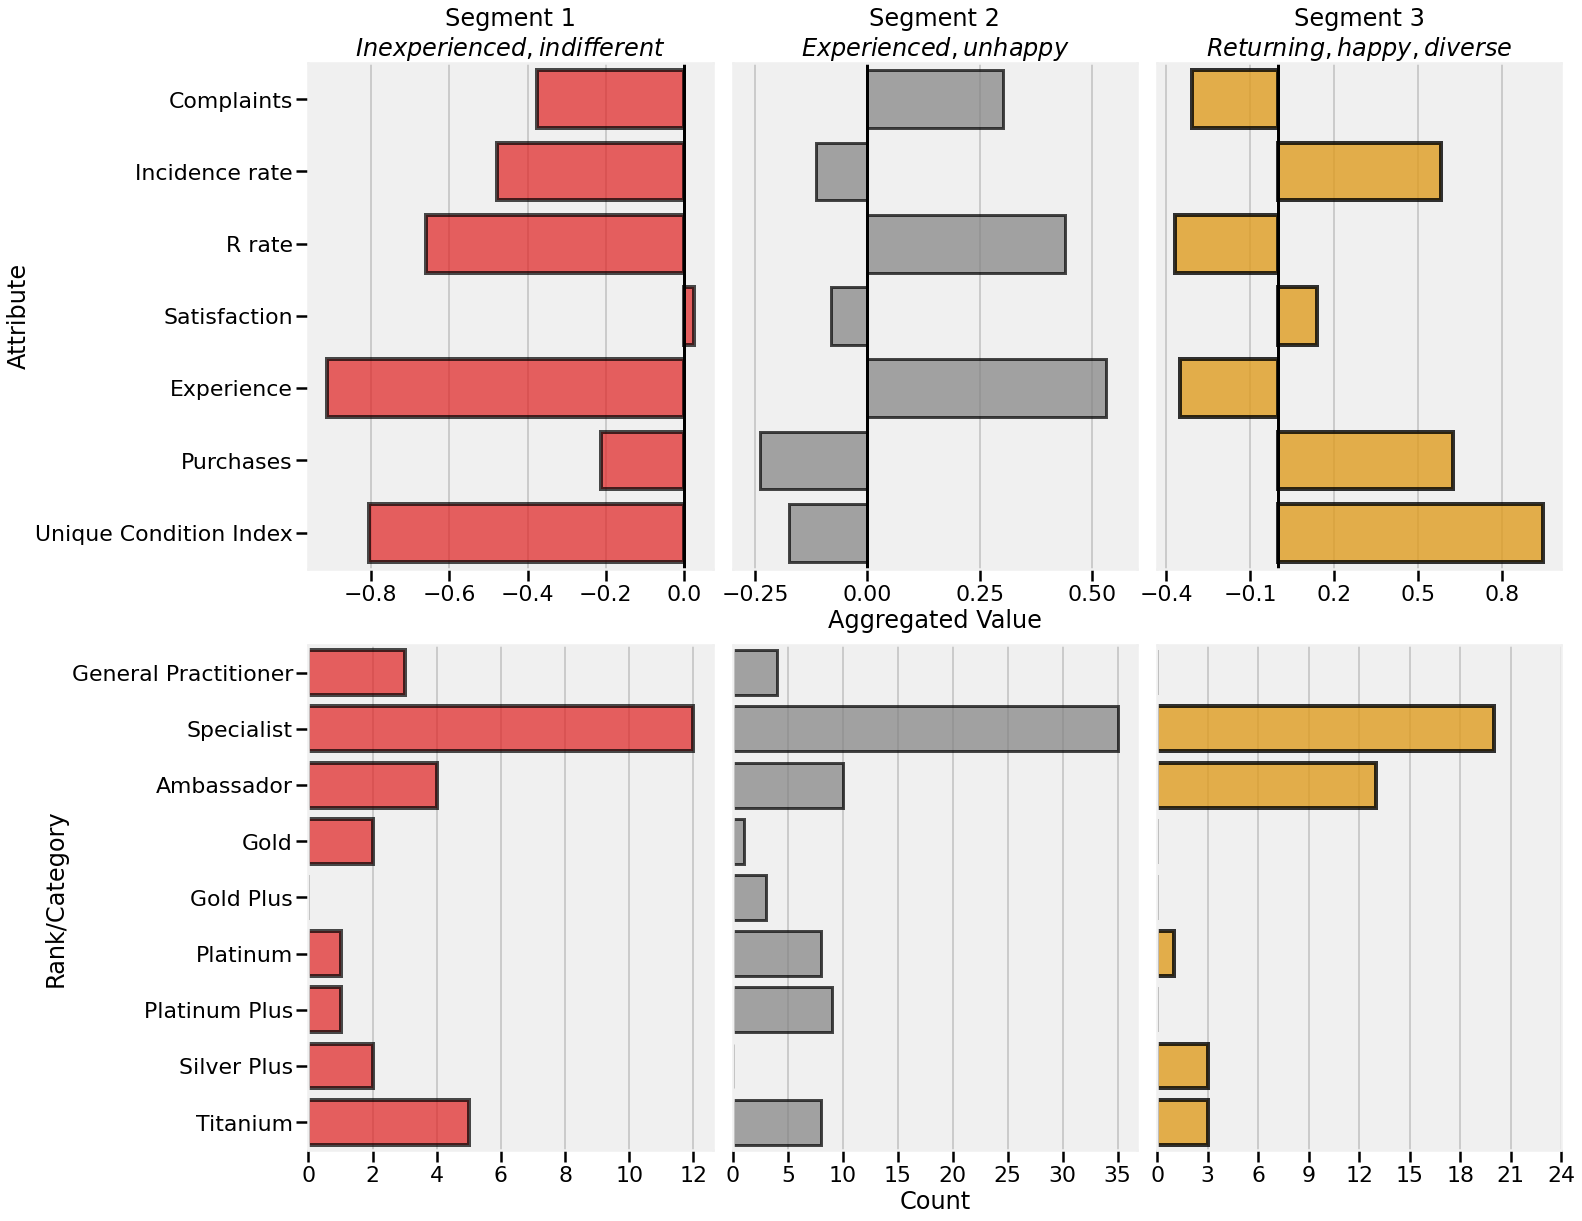

In [7]:
# Illustrate cluster profiles
with sns.plotting_context('poster'):
    
    # Fig, axis
    fig, (continuous, categories) = plt.subplots(2, 3, figsize=(20, 20), gridspec_kw={'wspace': 0.05, 'hspace': 0.15})
    
    # Iterate over and plot accordingly
    con, cat = chart.query('prep == "con"'), chart.query('prep == "cat"')
    
    # Color prop dict
    plot_profiles = {1: {'edgecolor': 'black', 'linewidth': 4, 'color': 'red', 'alpha': .7},
                     2: {'edgecolor': 'black', 'linewidth': 3, 'color': 'grey', 'alpha': .7},
                     3: {'edgecolor': 'black', 'linewidth': 4, 'color': 'orange', 'alpha': .8}
                    }
    
    # Plot continuous profiles
    for ax, (cl, seg) in zip(continuous, con.groupby('Segment')):
        
        # Bar plot with properties
        sns.barplot(data=seg, x='Aggregate', y='Attribute', ax=ax, **plot_profiles[cl])
        ax.axvline(0, color='black', alpha=1)
        
        # Clean up 
        if cl in [2, 3]: ax.set(yticks=[], ylabel='')
        ax.set(xlabel='') if cl != 2 else ax.set(xlabel='Aggregated Value')
            
        
    # Plot categorical profiles
    for ax, (cl, seg) in zip(categories, cat.groupby('Segment')):
        
        # Bar plot with properties
        sns.barplot(data=seg, x='Aggregate', y='Attribute', ax=ax, **plot_profiles[cl])
        
        # Clean up
        if cl in [2, 3]: ax.set(yticks=[], ylabel='') 
        ax.set(xlabel='') if cl != 2 else ax.set(xlabel='Count')
    
    # Specific cleanups
    categories[0].set(ylabel='Rank/Category')
    continuous[1].set(xlim=(-0.3, 0.6), xticks=[-0.25, 0, 0.25, 0.5])
    continuous[2].set(xticks=np.arange(-0.4, 1, 0.3))
    categories[2].set(xticks=np.arange(0, 25, 3))
    
    # Add titles
    seg_titles = {1: 'Segment 1\n$Inexperienced, indifferent$',
                  2: 'Segment 2\n$Experienced, unhappy$',
                  3: 'Segment 3\n$Returning, happy, diverse$'}
    
    for k, t in seg_titles.items():
        continuous[k-1].set_title(t)
    

In [8]:
# Segment profile
spectra_df['Segment'].value_counts(normalize=True).sort_index().round(2).to_frame('Proportion of sample').rename_axis(index='Segment Number')

,Proportion of sample
Segment Number,
1,0.20
2,0.53
3,0.27


The above plot highlights the distinct profile the three new segments have. These are described simply below:
- **Segment One**. Doctors here have low *experience* with the company, lower rates of *purchases*, *R* and *incidence* rates, and give fewer *complaints* They also treat very few *unique conditions*, and have very average reported *satisfaction*. There are more *general practitioners* here, and some individuals at the higher ranks. This would be a great group to target for more positive engagement and on-boarding marketing materials.
- **Segment Two**. Doctors here have high *R* rates, give more *complaints*, and have a high level of *experience* with the company. They make relatively fewer *purchases* and seem to treat fewer *unique conditions*. This segment, the largest in number, is diffuse in terms of its members and their rank and category. This set of doctors seem to be longstanding customers but are unhappy, and are making fewer purchases - a good target for focus groups to obtain detailed data on what is going wrong, and if this is perhaps related to the smaller number of conditions they treat.
- **Segment Three**. Doctors here make a lot of *purchases* and have high *incidence rates*, are relatively *satisfied*, and treat the most number of *unique conditions*. They make fewer *complaints* but have less *experience* with the company. They are comprised of a lot of *Ambassadors*. This group appears to be a relatively content customer base, and its important they stay that way through understanding what the company is doing right. 

A simple, memorable mapping could be:
- Segment One: **Inexperienced and indifferent doctors**.
- Segment Two: **Experienced but unhappy doctors**.
- Segment Three: **Returning, happy, and diverse doctors**.

# Technical Annexe
Significantly greater technical detail on the above sections are provided below, for interested readers.

## Feature engineering
The features used across the analysis were generated from the `doctors`, `complaints`, and `orders` datasets. Despite a large number of observations in the `doctors` dataset (437), relatively few of these were in the `complaints` dataset (just 16%). Given that complaints and purchases were a primary query, the smaller dataset was analysed. Features were engineered from across the datasets before being merged into one:

- From `doctors`, `Incidence rate`, `R rate`, `Satisfaction`, `Experience`, and `Purchases` were standardised and scaled as continuous features. The `Rank` and `Category` variables were one-hot-encoded, using "General Practitioner" and "Ambassador" as the reference categories, respectively - the former having two levels, and the latter eight.
- From `complaints`, the `Qty` variable was summed across complaint types per doctor, yielding a single count per doctor.
- The `orders` data was processed such that across the orders each doctor placed, the sum of unique conditions was calculated - doctors who treat more varied conditions may have more needs, and this feature could help discriminate this.

The final dataset contained 74 unique doctors, and 16 features. After merging, there were 55 missing data points for the `satisfaction` feature. This was imputed using K-nearest-neighbours imputation. 

## Assessing purchase ~ complaint association probabilistically
To assess the relationship between complaints and purchases, PyMC was used to fit a Bayesian negative-binomial regression, complaints alongside the 14 other features described above (purchases being the target variable). Negative-binomial regressions allow for the prediction of count data precisely, especially in situations where the variance of the count data is greater than the mean (here, the average purchase count is 10, while the variance is 130). Priors were set to be restrictive to help with the small dataset, avoiding overfitting, following a $\mathcal{N}(0, 1)$ distribution. 

The central feature is of course the `complaint` predictor, but the full model summary is printed below, highlighting those predictors which have a high (or indeed low) probability of being associated with increasing purchases, which may be valuable information. For example, the unique condition index is much more likely to have a negative association with purhcases; doctors who treat more conditions make fewer purchases. Those with higher incidence rates make more purchases. There is uncertainty in many of these estimates but they are provided for further insight.


In [9]:
# Tabulate results
(az
 .summary(trace, var_names='β', 
          filter_vars='like', 
          kind='stats', 
          hdi_prob=.95,
          stat_funcs={'Purchase Rate Change': lambda x: np.mean(np.exp(x)),
                      '95% lower': lambda x: az.hdi(np.exp(x), .95)[0],
                      '95% upper': lambda x: az.hdi(np.exp(x), .95)[1],
                      'Probability Positive': lambda x: np.mean(np.exp(x) > 1)})
 .drop(index=['β0'])
 .assign(Feature=lambda x: x.index.str.replace('β|\\[|\\]', '', regex=True).str.replace('_', ': '))
 .set_index('Feature')
 .filter(items=['Purchase Rate Change', '95% lower', '95% upper', 'Probability Positive'])
 .style
 .applymap(lambda x: 'color: blue' if x < .20 or x > .80 else None, subset=['Probability Positive'])
 .format('{:.2f}')
)

,Purchase Rate Change,95% lower,95% upper,Probability Positive
Feature,,,,
Complaints,1.06,0.89,1.25,0.75
Incidence rate,1.09,0.91,1.25,0.84
R rate,1.03,0.84,1.26,0.61
Satisfaction,1.08,0.89,1.25,0.80
Experience,1.15,0.95,1.36,0.93
Category: Specialist,2.29,1.00,3.85,0.99
Rank: Gold,0.38,0.10,0.81,0.02
Rank: Gold Plus,0.21,0.05,0.44,0.00
Rank: Platinum,0.30,0.15,0.46,0.00


## Customer segmentation - revealing three profiles 
The full 16-feature dataset was reduced to two dimensions using **spectral embedding**. This was chosen as, unlike other feature reduction methods, it focuses on maintaining local distances between observations in the reduced space. Following the embedding, **K-Means** was used to determine clusters. *K* was chosen by iterating over candidate cluster numbers and assessing the *silhouette coefficient*, which assesses the average distance between a point and its within-cluster neighbours compared to its between-cluster neighbours. Three clusters emerged as having the highest coefficient, 0.47.

A scatter plot of the resulting two-dimensional embedding and clusters is shown below, highlighting how the embedding retained distances that K-Means identified easily. 

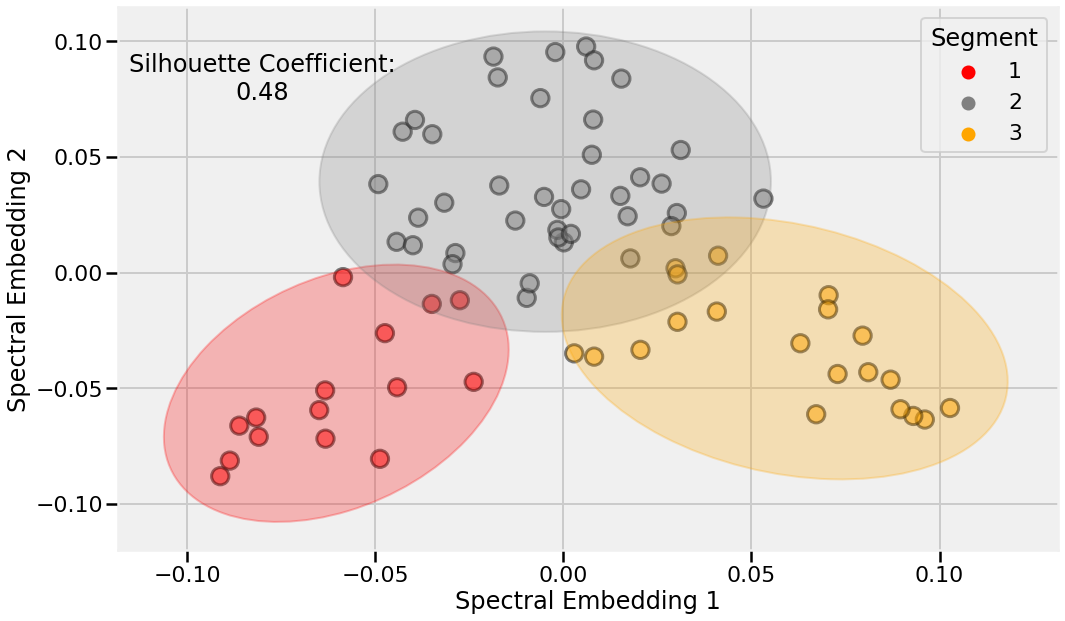

In [10]:
# Plot two dimensional scatter
with sns.plotting_context('poster'):
    
    # figure, axis
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    
    # Seaborn scatter on embeddings
    sns.scatterplot(data=spectra_df, x='spec_1', y='spec_2', hue='Segment', palette=['red', 'grey', 'orange'], 
                    s=300, alpha=.5, edgecolor='black', linewidth=3)
    # Set labels
    ax.set(ylabel='Spectral Embedding 2', xlabel='Spectral Embedding 1')
    
    # Add an ellipse according to cluster centers
    ellipse_params = {1: {'width': 0.08, 'height': 0.12, 'angle': 150., 'color': 'red', 'alpha': .25},
                      2: {'width': 0.12, 'height': 0.13, 'angle': 0., 'color': 'grey', 'alpha': .25},
                      3: {'width': 0.10, 'height': 0.13, 'angle': 50., 'color': 'orange', 'alpha': .25}}
    
    # Add silhouette coef
    ax.annotate(f'Silhouette Coefficient:\n{best_sc:.2f}', (-0.08, 0.075), horizontalalignment='center')
    
    # Add ellipses
    for index, params in ellipse_params.items():
        
        # Create ellipse
        ellipse = Ellipse(xy=tuple(final_k.cluster_centers_[index-1, :]), **params)
        ax.add_patch(ellipse)

In [11]:
%load_ext watermark
%watermark --iversions

pandas    : 1.4.3
arviz     : 0.12.1
pymc      : 4.1.4
matplotlib: 3.5.2
scipy     : 1.9.0
seaborn   : 0.11.1
numpy     : 1.23.1

